In [1]:
# Mount Google Drive
from google.colab import drive
import os

drive.mount('/content/gdrive')
# Define base folder path
base_path = '/content/gdrive/MyDrive/RGB_data_stream'

Mounted at /content/gdrive


In [2]:
import os

# Gets label
csv_path = os.path.join(base_path,'data/3DYoga90_corrected.csv')

# Gets valid samples
sequence_path = os.path.join(base_path, 'short/downloaded_log.txt')

# Path to save the model
save_path = os.path.join(base_path, 'nov12_unknown_attention')
os.makedirs(save_path, exist_ok=True)

# Classification classes
pose_list = ['mountain', 'half-way-lift', 'standing-forward-bend', 'downward-dog']
NUM_CLASSES = len(pose_list)

# Original Downloaded Seqeuence
video_dir = os.path.join(base_path, 'short')

# Pre_processed to tensor to make training fast # Makes video_dir redundant
preprocessed_dir = os.path.join(base_path, 'complete_pre_processed')
# os.makedirs(preprocessed_dir, exist_ok=True)
assert os.path.isdir(preprocessed_dir), f"Directory '{preprocessed_dir}' does not exist."

# Horizontal Flip
horz_aug = os.path.join(base_path, 'horz_aug')
assert os.path.isdir(horz_aug), f"Directory '{horz_aug}' does not exist."

# Gaussian Blur
gaussian_blur_aug = os.path.join(base_path, 'gaussian_blur_aug')
assert os.path.isdir(gaussian_blur_aug), f"Directory '{gaussian_blur_aug}' does not exist."

# Random Resize Crop
resize_aug = os.path.join(base_path, 'complete_pre_processed')
assert os.path.isdir(resize_aug), f"Directory '{resize_aug}' does not exist."


In [3]:
# Constants
FRAME_HEIGHT = 224
FRAME_WIDTH = 224
SEQUENCE_LENGTH = 16

BATCH_SIZE = 16
LEARNING_RATE = 0.0001
VALIDATION_SPLIT = 0.2
TEST_SPLIT = 0.1
NUM_EPOCHS = 50

# Dataset

Work Left
1. Data Augmentation
2. Expanding to more classes

In [4]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset
import torchvision.transforms.v2 as T
import random

class VideoAugmentationPipeline:
    """Video augmentation pipeline using batch transforms from torchvision.transforms.v2"""
    def __init__(self, spatial_aug_config=None, temporal_aug_config=None):

        self.spatial_aug_config = spatial_aug_config or {
            'random_resized_crop': {'enabled': False, 'scale': (0.9, 1.0)},  # Changed scale to (0.9, 1.0)
            'random_horizontal_flip': {'enabled': True, 'p': 0.3},  # Changed probability to 0.3
            'color_jitter': {'enabled': False, 'brightness': 0.01, 'contrast': 0.01, 'saturation': 0.01, 'p': 0.5},  # Reduced values
            'gaussian_blur': {'enabled': True, 'p': 0.1},  # Changed probability to 0.1
            'random_rotation': {'enabled': True, 'degrees': (-5, 5)},  # Reduced rotation degrees
        }

        self.temporal_aug_config = temporal_aug_config or {
            'temporal_crop': {'enabled': True, 'crop_size': 0.9},  # Changed crop size to 0.9
            'temporal_mask': {'enabled': True, 'n_masks': 1, 'mask_size': 0.05},  # Reduced number of masks and size
        }


        # Build transforms that can handle batch inputs
        self.spatial_transforms = self._build_spatial_transforms()

    def _build_spatial_transforms(self):
        """Build composition of spatial transforms that support batch processing"""
        transform_list = []

        if self.spatial_aug_config['random_resized_crop']['enabled']:
            transform_list.append(
                T.RandomResizedCrop(
                    size=(224, 224),
                    scale=self.spatial_aug_config['random_resized_crop']['scale'],
                    antialias=True
                )
            )

        if self.spatial_aug_config['random_horizontal_flip']['enabled']:
            transform_list.append(
                T.RandomHorizontalFlip(p=self.spatial_aug_config['random_horizontal_flip']['p'])
            )

        if self.spatial_aug_config['color_jitter']['enabled']:
            transform_list.append(
                T.ColorJitter(
                    brightness=self.spatial_aug_config['color_jitter']['brightness'],
                    contrast=self.spatial_aug_config['color_jitter']['contrast'],
                    saturation=self.spatial_aug_config['color_jitter']['saturation']
                )
            )

        if self.spatial_aug_config['gaussian_blur']['enabled']:
            transform_list.append(
                T.GaussianBlur(
                    kernel_size=(5, 5),
                    sigma=(0.1, 1.0)
                )
            )

        if self.spatial_aug_config['random_rotation']['enabled']:
            transform_list.append(
                T.RandomRotation(
                    degrees=self.spatial_aug_config['random_rotation']['degrees'],
                    interpolation=T.InterpolationMode.BILINEAR
                )
            )

        if self.spatial_aug_config['color_jitter']['enabled']:
        # Always normalize at the end
            transform_list.extend([
                T.ConvertImageDtype(torch.float32),
                T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
            ])

        return T.Compose(transform_list)

    def apply_temporal_augmentation(self, video_tensor):
        """Apply temporal augmentations to video tensor"""
        if not any(cfg['enabled'] for cfg in self.temporal_aug_config.values()):
            return video_tensor

        T, C, H, W = video_tensor.shape

        # Temporal crop
        if self.temporal_aug_config['temporal_crop']['enabled']:
            crop_size = int(T * self.temporal_aug_config['temporal_crop']['crop_size'])
            start_idx = random.randint(0, T - crop_size)
            video_tensor = video_tensor[start_idx:start_idx + crop_size]

        # Temporal masking
        if self.temporal_aug_config['temporal_mask']['enabled']:
            T = len(video_tensor)
            mask_size = int(T * self.temporal_aug_config['temporal_mask']['mask_size'])
            for _ in range(self.temporal_aug_config['temporal_mask']['n_masks']):
                if random.random() < 0.5:
                    start_idx = random.randint(0, T - mask_size)
                    video_tensor[start_idx:start_idx + mask_size] = 0

        return video_tensor

    def __call__(self, video_tensor):
        """Apply transforms to entire video tensor at once"""
        # Input shape: [T, C, H, W]
        # Reshape to [T, C, H, W] -> [1, T, C, H, W] for batch processing
        video_tensor = video_tensor.unsqueeze(0)

        # Apply spatial transforms to entire video tensor at once
        # transforms.v2 will maintain temporal consistency automatically
        video_tensor = self.spatial_transforms(video_tensor)

        # Remove batch dimension
        video_tensor = video_tensor.squeeze(0)

        # Apply temporal augmentations
        # video_tensor = self.apply_temporal_augmentation(video_tensor)

        return video_tensor

In [5]:
import os
import torch
import pandas as pd
import numpy as np
from torchvision.transforms import transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import imageio
import random

class YogaVideoDataset(Dataset):
    def __init__(self, csv_path, sequence_path, pose_list, video_dir, preprocessed_dir,
                 spatial_aug_config=None, temporal_aug_config=None, use_augmentation=True, aug_ratio = 0.5):
        with open(sequence_path) as f:
            sequence_list = f.read().splitlines()
            sequence_list = [int(x) for x in sequence_list]

        self.df = pd.read_csv(csv_path)
        self.df = self.df[self.df['sequence_id'].isin(sequence_list)]
        self.df = self.df[self.df['l3_pose'].isin(pose_list)]

        self.pose_to_idx = {pose: idx for idx, pose in enumerate(pose_list)}
        self.length_of_dataset = len(self.df)

        self.video_dir = video_dir
        self.preprocessed_dir = preprocessed_dir
        self.use_augmentation = use_augmentation

        # Initialize augmentation pipeline
        self.augmentation_pipeline = VideoAugmentationPipeline(
            spatial_aug_config=spatial_aug_config,
            temporal_aug_config=temporal_aug_config
        )

        self.cache = dict()
        self.augmentation_ratio = aug_ratio

    def __len__(self):
        return self.length_of_dataset

    def __getitem__(self, i):
        sequence_id = self.df.iloc[i]['sequence_id']
        pose = self.df.iloc[i]['l3_pose']
        label = self.pose_to_idx[pose]

        # Load preprocessed frames
        if sequence_id in self.cache:
            frames = self.cache[sequence_id]
        else:
            file_path = os.path.join(self.preprocessed_dir, f"{sequence_id}.pt")
            frames = torch.load(file_path, weights_only=True)
            # self.cache[sequence_id] = frames

        # Choose whether to use augmented or original data
        use_augmented_data = self.use_augmentation and self.augmentation_ratio < random.random()
        if use_augmented_data:
            frames = self.augmentation_pipeline(frames)

        # save_path = os.path.join(horz_aug, f'{sequence_id}.pt')
        # torch.save(frames, save_path)
        return frames, label

In [6]:
from torch.nn.utils.rnn import pad_sequence

def collate_fn(batch):
    frames, labels = zip(*batch)  # Separate frames and labels

    # Pad the sequences of frames for each video in the batch along the sequence dimension
    frames_padded = pad_sequence(frames, batch_first=True, padding_value=0)  # Shape: [batch_size, max_seq_len, 3, 224, 224]
    lengths = torch.tensor([len(seq) for seq in frames])  # Record original sequence lengths

    labels = torch.tensor(labels)

    return frames_padded, labels, lengths  # Return lengths for packing

# Model
``` (mobile_net to get feature map and LSTM to go through the frame sequences)```
Trying out average of LSTM from each time_step
Work Left
1. Using only last time step output from LSTM to using average value, max value, using attention mechanism
2. Using other imagenet model to extract the feature map

In [7]:
import torch
import torch.nn as nn
import torchvision.models as models
import torch.nn.functional as F
import torch.nn.utils.rnn as rnn_utils

class AttentionLayer(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(AttentionLayer, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size

        self.W = nn.Linear(input_size, hidden_size)
        self.V = nn.Linear(hidden_size, 1)

    def forward(self, lstm_output, mask=None):
        # lstm_output shape: (batch_size, seq_length, hidden_size*2)
        batch_size, seq_length, _ = lstm_output.size()

        # Calculate attention scores
        att_scores = self.V(torch.tanh(self.W(lstm_output)))  # (batch_size, seq_length, 1)
        att_scores = att_scores.squeeze(-1)  # (batch_size, seq_length)

        # Apply mask if provided
        if mask is not None:
            att_scores = att_scores.masked_fill(mask == 0, -1e9)

        # Normalize attention scores
        att_weights = F.softmax(att_scores, dim=1)  # (batch_size, seq_length)

        # Compute weighted sum of LSTM outputs
        context = (lstm_output * att_weights.unsqueeze(-1)).sum(1)  # (batch_size, hidden_size*2)

        return context, att_weights

class CNNLSTMATT(nn.Module):
    def __init__(self, num_classes, lstm_hidden_size=512, lstm_layers=2, dropout=0.5):
        super(CNNLSTMATT, self).__init__()

        # Load pretrained ResNet18
        resnet = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
        # Extract all layers except the final fully connected layer
        self.features = nn.Sequential(*list(resnet.children())[:-2])
        self.pool = nn.AdaptiveAvgPool2d((1, 1))

        # Initially freeze all ResNet parameters
        self._freeze_features()

        # ResNet18 outputs 512 features after pooling
        self.feature_size = 512

        # Bidirectional LSTM layers
        self.lstm = nn.LSTM(
            input_size=self.feature_size,
            hidden_size=lstm_hidden_size,
            num_layers=lstm_layers,
            batch_first=True,
            bidirectional=True,
            dropout=dropout if lstm_layers > 1 else 0
        )

        # Attention layer
        self.attention = AttentionLayer(input_size=lstm_hidden_size*2, hidden_size=lstm_hidden_size)

        # Modified classifier to handle attention-weighted LSTM output
        self.classifier = nn.Sequential(
            nn.Linear(lstm_hidden_size*2, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(dropout),

            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(dropout),

            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(dropout / 2),

            nn.Linear(128, num_classes)
        )

        # Initialize weights for the classifier layers
        self._initialize_weights()

    def _initialize_weights(self):
        for m in self.classifier.modules():
            if isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm1d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def _freeze_features(self):
        for param in self.features.parameters():
            param.requires_grad = False

    def unfreeze_features_gradually(self, num_layers=3, start_from_end=True):
        """
        Unfreeze a specified number of convolutional layers from ResNet.
        Args:
            num_layers: Number of layers to unfreeze
            start_from_end: If True, start unfreezing from the end (default)
        """
        # First freeze all layers
        self._freeze_features()

        # Get list of all feature layers
        features_list = list(self.features.modules())
        conv_layers = [m for m in features_list if isinstance(m, nn.Conv2d)]

        # Determine which layers to unfreeze
        if start_from_end:
            layers_to_unfreeze = conv_layers[-num_layers:]
        else:
            layers_to_unfreeze = conv_layers[:num_layers]

        # Unfreeze the selected layers
        for layer in layers_to_unfreeze:
            for param in layer.parameters():
                param.requires_grad = True

    # def forward(self, x, lengths):
    #     batch_size, seq_length, c, h, w = x.size()

    #     # Process each frame through the CNN feature extractor
    #     x = x.view(batch_size * seq_length, c, h, w)
    #     x = self.features(x)
    #     x = self.pool(x)
    #     x = x.view(batch_size, seq_length, self.feature_size)

    #     # Pack the sequence for LSTM to handle variable sequence lengths
    #     packed_x = rnn_utils.pack_padded_sequence(x, lengths.cpu(), batch_first=True, enforce_sorted=False)

    #     # Bidirectional LSTM processing
    #     packed_lstm_out, (h_n, c_n) = self.lstm(packed_x)
    #     lstm_out, _ = rnn_utils.pad_packed_sequence(packed_lstm_out, batch_first=True)

    #     # Attention layer
    #     # context, att_weights = self.attention(lstm_out, mask=rnn_utils.sequence_mask(lengths, lstm_out.size(1)))
    #     mask = torch.zeros(lstm_out.size(0), lstm_out.size(1), device=lstm_out.device)
    #     for i, length in enumerate(lengths):
    #         mask[i, :length] = 1
    #     mask = mask.bool()

    #     # Attention layer
    #     context, att_weights = self.attention(lstm_out, mask=mask)

    #     # Classification
    #     x = self.classifier(context)
    #     return x

    def forward(self, x, lengths):
        batch_size, seq_length, c, h, w = x.size()

        # Process each frame through the CNN feature extractor
        x = x.view(batch_size * seq_length, c, h, w)
        x = self.features(x)
        x = self.pool(x)
        x = x.view(batch_size, seq_length, self.feature_size)

        # Pack the sequence for LSTM to handle variable sequence lengths
        packed_x = rnn_utils.pack_padded_sequence(x, lengths.cpu(), batch_first=True, enforce_sorted=False)

        # Bidirectional LSTM processing
        packed_lstm_out, (h_n, c_n) = self.lstm(packed_x)
        lstm_out, _ = rnn_utils.pad_packed_sequence(packed_lstm_out, batch_first=True)

        # Create attention mask more efficiently
        # lengths is assumed to be a tensor with shape (batch_size,)
        max_len = lstm_out.size(1)
        mask = torch.arange(max_len, device=lengths.device).expand(len(lengths), max_len) < lengths.unsqueeze(1)

        # Apply the attention layer
        context, att_weights = self.attention(lstm_out, mask=mask)

        # Classification
        x = self.classifier(context)
        return x

    def get_trainable_params(self):
        """Return the number of trainable parameters"""
        return sum(p.numel() for p in self.parameters() if p.requires_grad)

    def count_parameters(self):
        total_params = 0
        for name, parameter in self.named_parameters():
            if parameter.requires_grad:
                params = parameter.numel()
                print(f"{name}: {params}")
                total_params += params
        print(f"Total Trainable Params: {total_params}")

In [8]:
from torch.utils.data import random_split

def train_val_test_split(dataset):
    total_size = len(dataset)
    test_size = int(TEST_SPLIT * total_size)
    val_size = int(VALIDATION_SPLIT * total_size)
    train_size = total_size - val_size - test_size

    train_dataset, val_dataset, test_dataset = random_split(
        dataset,
        [train_size, val_size, test_size],
        generator=torch.Generator().manual_seed(42)  # For reproducibility
    )

    return train_dataset, val_dataset, test_dataset

def create_data_loaders(train_dataset, val_dataset, test_dataset):
    train_loader = DataLoader(
        train_dataset,
        batch_size=BATCH_SIZE,
        shuffle=True,
        num_workers=2,
        pin_memory = True,
        collate_fn = collate_fn
    )

    val_loader = DataLoader(
        val_dataset,
        batch_size=BATCH_SIZE,
        shuffle=False,
        num_workers=2,
        pin_memory = True,
        collate_fn = collate_fn
    )

    test_loader = DataLoader(
        test_dataset,
        batch_size=BATCH_SIZE,
        shuffle=False,
        num_workers=2,
        pin_memory = True,
        collate_fn = collate_fn
    )

    return train_loader, val_loader, test_loader

In [9]:
def plot_training_curves(history, fsave='training_curves.png'):
    tsave = os.path.join(save_path, fsave)
    # plt.style.use('seaborn')
    fig, axs = plt.subplots(2, 3, figsize=(18, 10))

    # Loss curves
    axs[0, 0].plot(history['train_loss'], label='Train Loss', marker='o')
    axs[0, 0].plot(history['val_loss'], label='Validation Loss', marker='o')
    axs[0, 0].set_title('Loss')
    axs[0, 0].legend()

    # Accuracy curves
    axs[0, 1].plot(history['train_acc'], label='Train Accuracy', marker='o')
    axs[0, 1].plot(history['val_acc'], label='Validation Accuracy', marker='o')
    axs[0, 1].set_title('Accuracy')
    axs[0, 1].legend()

    # Learning rate
    axs[0, 2].plot(history['learning_rates'], label='Learning Rate', marker='o')
    axs[0, 2].set_title('Learning Rate')
    axs[0, 2].set_yscale('log')
    axs[0, 2].legend()

    # Precision
    axs[1, 0].plot(history['train_precision'], label='Train Precision', marker='o')
    axs[1, 0].plot(history['val_precision'], label='Validation Precision', marker='o')
    axs[1, 0].set_title('Precision')
    axs[1, 0].legend()

    # Recall
    axs[1, 1].plot(history['train_recall'], label='Train Recall', marker='o')
    axs[1, 1].plot(history['val_recall'], label='Validation Recall', marker='o')
    axs[1, 1].set_title('Recall')
    axs[1, 1].legend()

    # F1 Score
    axs[1, 2].plot(history['train_f1'], label='Train F1', marker='o')
    axs[1, 2].plot(history['val_f1'], label='Validation F1', marker='o')
    axs[1, 2].set_title('F1 Score')
    axs[1, 2].legend()

    for ax in axs.flat:
        ax.set_xlabel('Epoch')
        ax.grid(True)

    plt.tight_layout()
    plt.savefig(tsave)
    plt.show()
    plt.close()


In [10]:
class EarlyStopping:
    """Early stopping to prevent overfitting"""
    def __init__(self, patience=7, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        # on default = 7 successive val_loss increase stop
        elif val_loss > self.best_loss - self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.counter = 0

In [11]:
import os
import torch
def save_checkpoint(model, optimizer, epoch, history, best_path=None):
    if best_path is not None:
        chk_path = os.path.join(save_path, f'best_model.pth')
        print(f"Saving checkpoint to {chk_path}")
    else:
        chk_path = os.path.join(save_path, f'checkpath_model.pth')
        print(f"Saving checkpoint to {chk_path}")

    # Combine model, optimizer, and history into one dictionary
    checkpoint = {
        'epoch': epoch + 1,  # Save the next epoch number for resuming
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'history': history  # Save history along with the model and optimizer
    }

    # Save everything in a single file using torch.save
    torch.save(checkpoint, chk_path)
    print(f"Checkpoint saved at epoch {epoch + 1}")

In [12]:
def load_checkpoint(model, optimizer, checkpoint_path):
    """
    Load model and training state from a checkpoint
    """
    print(f"Loading checkpoint from {checkpoint_path}")
    checkpoint = torch.load(checkpoint_path, weights_only = False)

    # Load model and optimizer states
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

    # Get the epoch number to resume from
    start_epoch = checkpoint['epoch']

    # Load training history with new metrics
    history = checkpoint.get('history', {
        'train_loss': [], 'val_loss': [],
        'train_acc': [], 'val_acc': [],
        'train_precision': [], 'train_recall': [], 'train_f1': [],
        'val_precision': [], 'val_recall': [], 'val_f1': [],
        'learning_rates': []
    })

    return model, optimizer, start_epoch, history


In [13]:
import os
import torch
from torch.optim import lr_scheduler
from sklearn.metrics import precision_score, recall_score, f1_score
from tqdm import tqdm

def train_model(model, train_loader, val_loader, criterion, optimizer, dataset, num_epochs=50, patience=18, log_interval=10, checkpoint_path=None, unfreeze_epoch=5, num_layers_unfreeze=3):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    print("Using device:", device)

    # Initialize scheduler
    scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=4)

    # Initialize early stopping
    early_stopping = EarlyStopping(patience=patience, min_delta=1e-4)

    start_epoch = 0
    best_val_loss = float('inf')

    # Initialize history for loss, accuracy, precision, recall, and F1
    history = {
        'train_loss': [], 'val_loss': [],
        'train_acc': [], 'val_acc': [],
        'train_precision': [], 'train_recall': [], 'train_f1': [],
        'val_precision': [], 'val_recall': [], 'val_f1': [],
        'learning_rates': []
    }

    # Check for checkpoint and load if available
    if checkpoint_path and os.path.exists(checkpoint_path):
        model, optimizer, start_epoch, history = load_checkpoint(model, optimizer, checkpoint_path)
        print(f"Resuming training from epoch {start_epoch}")
        torch.cuda.empty_cache()

    for epoch in range(start_epoch, num_epochs):
        if epoch == unfreeze_epoch:
            print(f"Unfreezing last {num_layers_unfreeze} layers of CNN")
            model.unfreeze_features_gradually(num_layers=num_layers_unfreeze)
        print(f'\nEpoch {epoch + 1}/{num_epochs}')
        # print("Augmeneted Use:", dataset.use_augmented)
        dataset.use_augmented = True

        current_lr = optimizer.param_groups[0]['lr']
        history['learning_rates'].append(current_lr)
        print(f"Current Learning Rate: {current_lr}")

        # Training phase
        model.train()
        train_loss, train_correct, train_total = 0.0, 0, 0
        train_true, train_pred = [], []

        train_loader_tqdm = tqdm(enumerate(train_loader), total=len(train_loader), desc="Training")
        for batch_idx, (inputs, labels, lengths) in train_loader_tqdm:
            inputs, labels, lengths = inputs.to(device), labels.to(device), lengths.to(device)
            optimizer.zero_grad()
            outputs = model(inputs, lengths)  # Pass sequence lengths to model forward function
            loss = criterion(outputs, labels)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()

            train_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            train_correct += (predicted == labels).sum().item()
            train_total += labels.size(0)

            # Collect true and predicted labels for precision/recall
            train_true.extend(labels.cpu().numpy())
            train_pred.extend(predicted.cpu().numpy())

            # Log batch-level updates
            if batch_idx % log_interval == 0:
                train_loader_tqdm.set_postfix({
                    'loss': train_loss / (batch_idx + 1),
                    'accuracy': 100.0 * train_correct / train_total
                })

        # Calculate training metrics
        train_loss /= len(train_loader.dataset)
        train_acc = 100.0 * train_correct / train_total
        train_precision = precision_score(train_true, train_pred, average='weighted')
        train_recall = recall_score(train_true, train_pred, average='weighted')
        train_f1 = f1_score(train_true, train_pred, average='weighted')

        dataset.use_augmented = False
        # Validation phase
        model.eval()
        val_loss, val_correct, val_total = 0.0, 0, 0
        val_true, val_pred = [], []

        val_loader_tqdm = tqdm(enumerate(val_loader), total=len(val_loader), desc="Validation")
        with torch.no_grad():
            for batch_idx, (inputs, labels, lengths) in val_loader_tqdm:
                inputs, labels, lengths = inputs.to(device), labels.to(device), lengths.to(device)
                outputs = model(inputs, lengths)  # Pass sequence lengths to model forward function
                loss = criterion(outputs, labels)

                val_loss += loss.item() * inputs.size(0)
                _, predicted = torch.max(outputs, 1)
                val_correct += (predicted == labels).sum().item()
                val_total += labels.size(0)

                # Collect true and predicted labels for precision/recall
                val_true.extend(labels.cpu().numpy())
                val_pred.extend(predicted.cpu().numpy())

                # Log batch-level updates for validation
                if batch_idx % log_interval == 0:
                    val_loader_tqdm.set_postfix({
                        'loss': val_loss / (batch_idx + 1),
                        'accuracy': 100.0 * val_correct / val_total
                    })

        # Calculate validation metrics
        val_loss /= len(val_loader.dataset)
        val_acc = 100.0 * val_correct / val_total
        val_precision = precision_score(val_true, val_pred, average='weighted')
        val_recall = recall_score(val_true, val_pred, average='weighted')
        val_f1 = f1_score(val_true, val_pred, average='weighted')

        # Update history
        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['train_acc'].append(train_acc)
        history['val_acc'].append(val_acc)
        history['train_precision'].append(train_precision)
        history['train_recall'].append(train_recall)
        history['train_f1'].append(train_f1)
        history['val_precision'].append(val_precision)
        history['val_recall'].append(val_recall)
        history['val_f1'].append(val_f1)

        # Print metrics at the end of the epoch
        print(f'\nEpoch {epoch + 1}/{num_epochs} Summary:')
        print(f'Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}% | Train Precision: {train_precision:.2f} | Train Recall: {train_recall:.2f} | Train F1: {train_f1:.2f}')
        print(f'Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}% | Val Precision: {val_precision:.2f} | Val Recall: {val_recall:.2f} | Val F1: {val_f1:.2f}')

        # Save the best model checkpoint
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_path = os.path.join(save_path, 'best_model.pth')
            save_checkpoint(model, optimizer, epoch, history, best_model_path)
            print(f"New best model saved! Validation Loss: {best_val_loss:.4f}")

        # Adjust learning rate based on validation loss
        scheduler.step(val_loss)

        # Check for early stopping
        early_stopping(val_loss)
        if early_stopping.early_stop:
            print("Early stopping triggered")
            break

    return model, history



In [14]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
import torch
import numpy as np
import os
from tqdm import tqdm

def evaluate_model(model, test_loader, criterion, class_names,spath=save_path, fsave='confusion_matrix.png'):
    """
    Evaluate model on test set

    Args:
        model: PyTorch model
        test_loader: DataLoader for test data
        criterion: Loss function
        class_names: List of class names
        save_path: Directory to save the plot
        fsave: Filename for confusion matrix plot
    """
    csave = os.path.join(spath, fsave)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    model.eval()

    test_loss = 0.0
    test_correct = 0
    test_total = 0
    all_predictions = []
    all_labels = []

    # Create progress bar
    test_loader_tqdm = tqdm(test_loader, desc="Testing")

    with torch.no_grad():
        for inputs, labels, length in test_loader_tqdm:
            inputs = inputs.to(device)
            labels = labels.to(device)
            length = length.to(device)

            # Forward pass
            outputs = model(inputs, length)
            loss = criterion(outputs, labels)
            test_loss += loss.item() * inputs.size(0)

            # Get predictions
            _, predicted = torch.max(outputs, 1)
            # Calculate accuracy
            test_correct += (predicted == labels).sum().item()
            test_total += labels.size(0)

            # Store predictions and labels for confusion matrix
            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Calculate metrics
    test_loss = test_loss / len(test_loader.dataset)
    accuracy = 100 * test_correct / test_total

    # Create confusion matrix
    cm = confusion_matrix(all_labels, all_predictions)

    # Plot confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')

    # Save the plot
    plt.savefig(csave)
    plt.show()
    plt.close()

    print(f'Test Loss: {test_loss:.4f}')
    print(f'Test Accuracy: {accuracy:.2f}%')

    return test_loss, accuracy

In [15]:
def main():
    print("Loading Data")
    aug_dirs={
        'flip': horz_aug,
        'blur': gaussian_blur_aug,
        # 'resize_crop': resize_aug
    }
    dataset = YogaVideoDataset(csv_path, sequence_path, pose_list, video_dir, preprocessed_dir)
    train_dataset, val_dataset, test_dataset = train_val_test_split(dataset)
    train_loader, val_loader, test_loader = create_data_loaders(train_dataset, val_dataset, test_dataset)
    print("Finished Loading Data")

    model = CNNLSTMATT(num_classes=NUM_CLASSES)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

    print("Training the model")
    checkpoint_path = os.path.join(save_path, 'best_model.pth')
    model, history = train_model(
        model,
        train_loader,
        val_loader,
        criterion,
        optimizer,
        dataset,
        NUM_EPOCHS,
        patience=10,
        log_interval=10,
        checkpoint_path=checkpoint_path
    )
    # Plot the training curves
    plot_training_curves(history)
    if checkpoint_path and os.path.exists(checkpoint_path):
            model, optimizer, start_epoch, history = load_checkpoint(
                model, optimizer, checkpoint_path
            )
            print(f"Resuming training from epoch {start_epoch}")
    evaluate_model(model, test_loader, criterion, pose_list)

    model_save_path = os.path.join(save_path, 'my_model.pth')
    torch.save(model.state_dict(), model_save_path)

In [45]:
def eval_best_model():
    print("Loading Data")
    aug_dirs={
        'flip': horz_aug,
        'blur': gaussian_blur_aug,
        'resize_crop': resize_aug
    }
    dataset = YogaVideoDataset(csv_path, sequence_path, pose_list, video_dir, preprocessed_dir)
    train_dataset, val_dataset, test_dataset = train_val_test_split(dataset)
    train_loader, val_loader, test_loader = create_data_loaders(train_dataset, val_dataset, test_dataset)
    model = CNNLSTMATT(num_classes=NUM_CLASSES)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
    checkpoint_path = os.path.join(save_path, 'best_model.pth')
    if checkpoint_path and os.path.exists(checkpoint_path):
            model, optimizer, start_epoch, history = load_checkpoint(
                model, optimizer, checkpoint_path
            )
            print(f"Resuming training from epoch {start_epoch}")
    evaluate_model(model, test_loader, criterion, pose_list)

In [17]:
# %pip install opencv-python
# %pip install imageio[ffmpeg]
# %pip install tqdm

Loading Data
Finished Loading Data


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 171MB/s]


Training the model
Using device: cuda
Loading checkpoint from /content/gdrive/MyDrive/RGB_data_stream/nov12_unknown_attention/best_model.pth
Resuming training from epoch 1

Epoch 2/50
Current Learning Rate: 0.0001


Validation: 100%|██████████| 9/9 [02:11<00:00, 14.62s/it, loss=48.8, accuracy=25]



Epoch 2/50 Summary:
Train Loss: 9.1372 | Train Acc: 24.33% | Train Precision: 0.38 | Train Recall: 0.24 | Train F1: 0.17
Val Loss: 2.9213 | Val Acc: 24.64% | Val Precision: 0.23 | Val Recall: 0.25 | Val F1: 0.21
Saving checkpoint to /content/gdrive/MyDrive/RGB_data_stream/nov12_unknown_attention/best_model.pth
Checkpoint saved at epoch 2
New best model saved! Validation Loss: 2.9213

Epoch 3/50
Current Learning Rate: 0.0001


Validation: 100%|██████████| 9/9 [00:35<00:00,  3.98s/it, loss=45.3, accuracy=25]



Epoch 3/50 Summary:
Train Loss: 8.9099 | Train Acc: 23.92% | Train Precision: 0.33 | Train Recall: 0.24 | Train F1: 0.17
Val Loss: 2.7597 | Val Acc: 32.61% | Val Precision: 0.33 | Val Recall: 0.33 | Val F1: 0.29
Saving checkpoint to /content/gdrive/MyDrive/RGB_data_stream/nov12_unknown_attention/best_model.pth
Checkpoint saved at epoch 3
New best model saved! Validation Loss: 2.7597

Epoch 4/50
Current Learning Rate: 0.0001


Validation: 100%|██████████| 9/9 [00:35<00:00,  3.94s/it, loss=36.1, accuracy=43.8]



Epoch 4/50 Summary:
Train Loss: 8.1830 | Train Acc: 22.89% | Train Precision: 0.35 | Train Recall: 0.23 | Train F1: 0.16
Val Loss: 2.2338 | Val Acc: 39.86% | Val Precision: 0.45 | Val Recall: 0.40 | Val F1: 0.38
Saving checkpoint to /content/gdrive/MyDrive/RGB_data_stream/nov12_unknown_attention/best_model.pth
Checkpoint saved at epoch 4
New best model saved! Validation Loss: 2.2338

Epoch 5/50
Current Learning Rate: 0.0001


Validation: 100%|██████████| 9/9 [00:32<00:00,  3.61s/it, loss=38, accuracy=37.5]



Epoch 5/50 Summary:
Train Loss: 7.8072 | Train Acc: 27.22% | Train Precision: 0.40 | Train Recall: 0.27 | Train F1: 0.23
Val Loss: 2.1589 | Val Acc: 47.83% | Val Precision: 0.53 | Val Recall: 0.48 | Val F1: 0.42
Saving checkpoint to /content/gdrive/MyDrive/RGB_data_stream/nov12_unknown_attention/best_model.pth
Checkpoint saved at epoch 5
New best model saved! Validation Loss: 2.1589
Unfreezing last 3 layers of CNN

Epoch 6/50
Current Learning Rate: 0.0001


Validation: 100%|██████████| 9/9 [00:36<00:00,  4.06s/it, loss=54.3, accuracy=25]



Epoch 6/50 Summary:
Train Loss: 7.2384 | Train Acc: 31.55% | Train Precision: 0.45 | Train Recall: 0.32 | Train F1: 0.28
Val Loss: 2.4344 | Val Acc: 41.30% | Val Precision: 0.43 | Val Recall: 0.41 | Val F1: 0.35

Epoch 7/50
Current Learning Rate: 0.0001


Validation: 100%|██████████| 9/9 [00:35<00:00,  3.90s/it, loss=39.1, accuracy=37.5]



Epoch 7/50 Summary:
Train Loss: 5.7769 | Train Acc: 34.85% | Train Precision: 0.50 | Train Recall: 0.35 | Train F1: 0.33
Val Loss: 2.0157 | Val Acc: 51.45% | Val Precision: 0.54 | Val Recall: 0.51 | Val F1: 0.47
Saving checkpoint to /content/gdrive/MyDrive/RGB_data_stream/nov12_unknown_attention/best_model.pth
Checkpoint saved at epoch 7
New best model saved! Validation Loss: 2.0157

Epoch 8/50
Current Learning Rate: 0.0001


Validation: 100%|██████████| 9/9 [00:32<00:00,  3.56s/it, loss=41.8, accuracy=43.8]



Epoch 8/50 Summary:
Train Loss: 4.7163 | Train Acc: 41.03% | Train Precision: 0.48 | Train Recall: 0.41 | Train F1: 0.38
Val Loss: 1.8398 | Val Acc: 56.52% | Val Precision: 0.59 | Val Recall: 0.57 | Val F1: 0.53
Saving checkpoint to /content/gdrive/MyDrive/RGB_data_stream/nov12_unknown_attention/best_model.pth
Checkpoint saved at epoch 8
New best model saved! Validation Loss: 1.8398

Epoch 9/50
Current Learning Rate: 0.0001


Validation: 100%|██████████| 9/9 [00:30<00:00,  3.39s/it, loss=48.1, accuracy=43.8]



Epoch 9/50 Summary:
Train Loss: 4.1498 | Train Acc: 45.36% | Train Precision: 0.53 | Train Recall: 0.45 | Train F1: 0.43
Val Loss: 1.7900 | Val Acc: 57.97% | Val Precision: 0.57 | Val Recall: 0.58 | Val F1: 0.55
Saving checkpoint to /content/gdrive/MyDrive/RGB_data_stream/nov12_unknown_attention/best_model.pth
Checkpoint saved at epoch 9
New best model saved! Validation Loss: 1.7900

Epoch 10/50
Current Learning Rate: 0.0001


Validation: 100%|██████████| 9/9 [00:37<00:00,  4.13s/it, loss=36.3, accuracy=50]


Epoch 10/50 Summary:
Train Loss: 3.6095 | Train Acc: 49.07% | Train Precision: 0.54 | Train Recall: 0.49 | Train F1: 0.47
Val Loss: 1.9661 | Val Acc: 56.52% | Val Precision: 0.59 | Val Recall: 0.57 | Val F1: 0.53

Epoch 11/50
Current Learning Rate: 0.0001



Validation: 100%|██████████| 9/9 [00:29<00:00,  3.32s/it, loss=27.1, accuracy=56.2]



Epoch 11/50 Summary:
Train Loss: 2.4929 | Train Acc: 57.32% | Train Precision: 0.62 | Train Recall: 0.57 | Train F1: 0.56
Val Loss: 1.4528 | Val Acc: 67.39% | Val Precision: 0.71 | Val Recall: 0.67 | Val F1: 0.66
Saving checkpoint to /content/gdrive/MyDrive/RGB_data_stream/nov12_unknown_attention/best_model.pth
Checkpoint saved at epoch 11
New best model saved! Validation Loss: 1.4528

Epoch 12/50
Current Learning Rate: 0.0001


Validation: 100%|██████████| 9/9 [00:31<00:00,  3.55s/it, loss=42.2, accuracy=56.2]


Epoch 12/50 Summary:
Train Loss: 2.3361 | Train Acc: 61.03% | Train Precision: 0.65 | Train Recall: 0.61 | Train F1: 0.60
Val Loss: 1.9595 | Val Acc: 63.04% | Val Precision: 0.72 | Val Recall: 0.63 | Val F1: 0.58

Epoch 13/50
Current Learning Rate: 0.0001



Validation: 100%|██████████| 9/9 [00:35<00:00,  3.90s/it, loss=41.8, accuracy=50]



Epoch 13/50 Summary:
Train Loss: 2.2465 | Train Acc: 61.65% | Train Precision: 0.63 | Train Recall: 0.62 | Train F1: 0.61
Val Loss: 1.3018 | Val Acc: 68.12% | Val Precision: 0.70 | Val Recall: 0.68 | Val F1: 0.66
Saving checkpoint to /content/gdrive/MyDrive/RGB_data_stream/nov12_unknown_attention/best_model.pth
Checkpoint saved at epoch 13
New best model saved! Validation Loss: 1.3018

Epoch 14/50
Current Learning Rate: 0.0001


Validation: 100%|██████████| 9/9 [00:31<00:00,  3.45s/it, loss=35.1, accuracy=56.2]


Epoch 14/50 Summary:
Train Loss: 1.6749 | Train Acc: 68.04% | Train Precision: 0.69 | Train Recall: 0.68 | Train F1: 0.68
Val Loss: 1.3810 | Val Acc: 72.46% | Val Precision: 0.74 | Val Recall: 0.72 | Val F1: 0.72

Epoch 15/50
Current Learning Rate: 0.0001



Validation: 100%|██████████| 9/9 [00:30<00:00,  3.35s/it, loss=30.3, accuracy=56.2]



Epoch 15/50 Summary:
Train Loss: 1.7242 | Train Acc: 69.48% | Train Precision: 0.70 | Train Recall: 0.69 | Train F1: 0.69
Val Loss: 1.2109 | Val Acc: 74.64% | Val Precision: 0.78 | Val Recall: 0.75 | Val F1: 0.74
Saving checkpoint to /content/gdrive/MyDrive/RGB_data_stream/nov12_unknown_attention/best_model.pth
Checkpoint saved at epoch 15
New best model saved! Validation Loss: 1.2109

Epoch 16/50
Current Learning Rate: 0.0001


Validation: 100%|██████████| 9/9 [00:33<00:00,  3.69s/it, loss=42.7, accuracy=62.5]


Epoch 16/50 Summary:
Train Loss: 1.5285 | Train Acc: 75.67% | Train Precision: 0.76 | Train Recall: 0.76 | Train F1: 0.75
Val Loss: 1.2691 | Val Acc: 76.09% | Val Precision: 0.79 | Val Recall: 0.76 | Val F1: 0.75

Epoch 17/50
Current Learning Rate: 0.0001



Validation: 100%|██████████| 9/9 [00:26<00:00,  2.92s/it, loss=42, accuracy=56.2]


Epoch 17/50 Summary:
Train Loss: 1.4780 | Train Acc: 72.78% | Train Precision: 0.74 | Train Recall: 0.73 | Train F1: 0.73
Val Loss: 1.2120 | Val Acc: 78.26% | Val Precision: 0.80 | Val Recall: 0.78 | Val F1: 0.78

Epoch 18/50
Current Learning Rate: 0.0001



Validation: 100%|██████████| 9/9 [00:27<00:00,  3.05s/it, loss=51.1, accuracy=56.2]


Epoch 18/50 Summary:
Train Loss: 1.3767 | Train Acc: 74.85% | Train Precision: 0.75 | Train Recall: 0.75 | Train F1: 0.75
Val Loss: 1.3651 | Val Acc: 74.64% | Val Precision: 0.80 | Val Recall: 0.75 | Val F1: 0.72

Epoch 19/50
Current Learning Rate: 0.0001



Validation: 100%|██████████| 9/9 [00:31<00:00,  3.47s/it, loss=19.1, accuracy=75]



Epoch 19/50 Summary:
Train Loss: 1.1634 | Train Acc: 79.79% | Train Precision: 0.80 | Train Recall: 0.80 | Train F1: 0.80
Val Loss: 0.7118 | Val Acc: 84.06% | Val Precision: 0.86 | Val Recall: 0.84 | Val F1: 0.84
Saving checkpoint to /content/gdrive/MyDrive/RGB_data_stream/nov12_unknown_attention/best_model.pth
Checkpoint saved at epoch 19
New best model saved! Validation Loss: 0.7118

Epoch 20/50
Current Learning Rate: 0.0001


Validation: 100%|██████████| 9/9 [00:31<00:00,  3.51s/it, loss=35.7, accuracy=62.5]


Epoch 20/50 Summary:
Train Loss: 1.1490 | Train Acc: 80.41% | Train Precision: 0.80 | Train Recall: 0.80 | Train F1: 0.80
Val Loss: 0.8932 | Val Acc: 78.26% | Val Precision: 0.81 | Val Recall: 0.78 | Val F1: 0.78

Epoch 21/50
Current Learning Rate: 0.0001



Validation: 100%|██████████| 9/9 [00:29<00:00,  3.30s/it, loss=38.5, accuracy=56.2]


Epoch 21/50 Summary:
Train Loss: 0.8462 | Train Acc: 84.74% | Train Precision: 0.85 | Train Recall: 0.85 | Train F1: 0.85
Val Loss: 1.3099 | Val Acc: 73.19% | Val Precision: 0.81 | Val Recall: 0.73 | Val F1: 0.73

Epoch 22/50
Current Learning Rate: 0.0001



Validation: 100%|██████████| 9/9 [00:35<00:00,  3.95s/it, loss=26.3, accuracy=68.8]



Epoch 22/50 Summary:
Train Loss: 0.8682 | Train Acc: 82.27% | Train Precision: 0.82 | Train Recall: 0.82 | Train F1: 0.82
Val Loss: 0.7777 | Val Acc: 83.33% | Val Precision: 0.85 | Val Recall: 0.83 | Val F1: 0.83

Epoch 23/50
Current Learning Rate: 0.0001


Validation: 100%|██████████| 9/9 [00:35<00:00,  3.94s/it, loss=48.4, accuracy=68.8]


Epoch 23/50 Summary:
Train Loss: 0.9870 | Train Acc: 80.82% | Train Precision: 0.81 | Train Recall: 0.81 | Train F1: 0.81
Val Loss: 1.4383 | Val Acc: 74.64% | Val Precision: 0.79 | Val Recall: 0.75 | Val F1: 0.73

Epoch 24/50
Current Learning Rate: 0.0001



Validation: 100%|██████████| 9/9 [00:28<00:00,  3.21s/it, loss=18.8, accuracy=87.5]


Epoch 24/50 Summary:
Train Loss: 0.8049 | Train Acc: 81.86% | Train Precision: 0.82 | Train Recall: 0.82 | Train F1: 0.82
Val Loss: 0.7636 | Val Acc: 86.23% | Val Precision: 0.88 | Val Recall: 0.86 | Val F1: 0.86

Epoch 25/50
Current Learning Rate: 1e-05



Validation: 100%|██████████| 9/9 [00:32<00:00,  3.65s/it, loss=25.1, accuracy=81.2]



Epoch 25/50 Summary:
Train Loss: 0.9204 | Train Acc: 82.89% | Train Precision: 0.83 | Train Recall: 0.83 | Train F1: 0.83
Val Loss: 0.8155 | Val Acc: 85.51% | Val Precision: 0.88 | Val Recall: 0.86 | Val F1: 0.86

Epoch 26/50
Current Learning Rate: 1e-05


Validation: 100%|██████████| 9/9 [00:30<00:00,  3.38s/it, loss=25.3, accuracy=68.8]


Epoch 26/50 Summary:
Train Loss: 0.8752 | Train Acc: 84.33% | Train Precision: 0.84 | Train Recall: 0.84 | Train F1: 0.84
Val Loss: 0.8775 | Val Acc: 81.16% | Val Precision: 0.84 | Val Recall: 0.81 | Val F1: 0.81

Epoch 27/50
Current Learning Rate: 1e-05



Validation: 100%|██████████| 9/9 [00:38<00:00,  4.33s/it, loss=20.3, accuracy=81.2]


Epoch 27/50 Summary:
Train Loss: 0.7067 | Train Acc: 84.33% | Train Precision: 0.84 | Train Recall: 0.84 | Train F1: 0.84
Val Loss: 0.9203 | Val Acc: 84.78% | Val Precision: 0.87 | Val Recall: 0.85 | Val F1: 0.85

Epoch 28/50
Current Learning Rate: 1e-05



Validation: 100%|██████████| 9/9 [00:31<00:00,  3.51s/it, loss=28.9, accuracy=68.8]


Epoch 28/50 Summary:
Train Loss: 0.5565 | Train Acc: 88.66% | Train Precision: 0.89 | Train Recall: 0.89 | Train F1: 0.89
Val Loss: 0.8734 | Val Acc: 84.06% | Val Precision: 0.86 | Val Recall: 0.84 | Val F1: 0.84

Epoch 29/50
Current Learning Rate: 1e-05



Validation: 100%|██████████| 9/9 [00:37<00:00,  4.20s/it, loss=19, accuracy=87.5]



Epoch 29/50 Summary:
Train Loss: 0.9205 | Train Acc: 85.57% | Train Precision: 0.86 | Train Recall: 0.86 | Train F1: 0.86
Val Loss: 1.1513 | Val Acc: 84.06% | Val Precision: 0.87 | Val Recall: 0.84 | Val F1: 0.84
Early stopping triggered


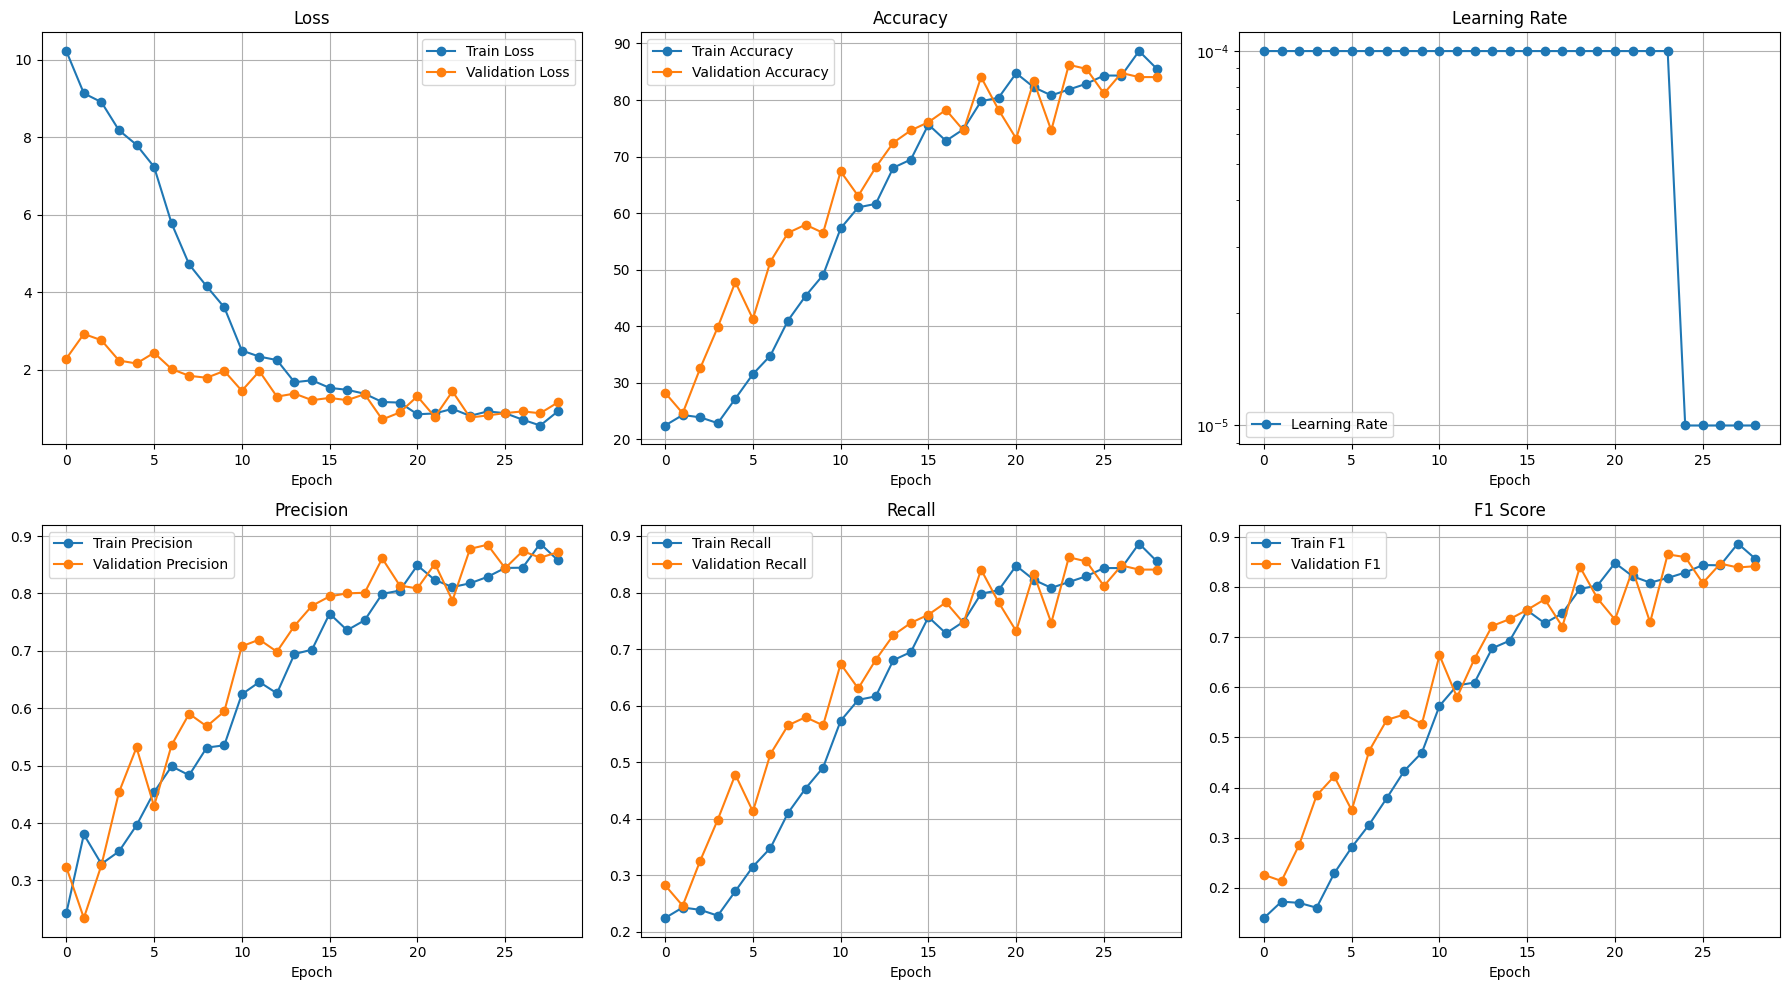

Loading checkpoint from /content/gdrive/MyDrive/RGB_data_stream/nov12_unknown_attention/best_model.pth
Resuming training from epoch 19


Testing: 100%|██████████| 5/5 [01:12<00:00, 14.58s/it]


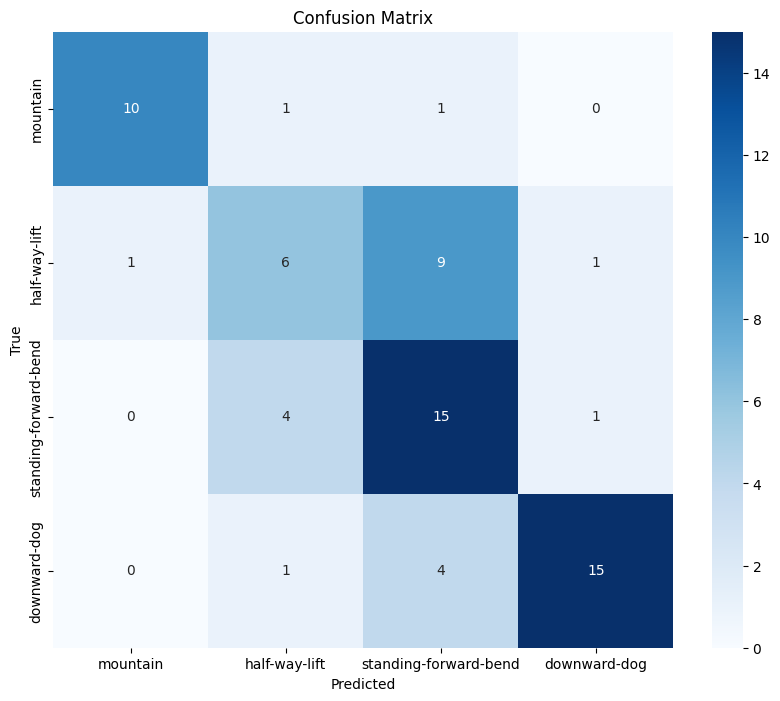

Test Loss: 1.2474
Test Accuracy: 66.67%


In [18]:
main()

In [19]:
# plot_training_curves(history)
# evaluate_model(model, test_loader, criterion, pose_list)

Loading Data
Loading checkpoint from /content/gdrive/MyDrive/RGB_data_stream/nov12_unknown_attention/best_model.pth
Resuming training from epoch 19


Testing: 100%|██████████| 5/5 [00:19<00:00,  3.93s/it]


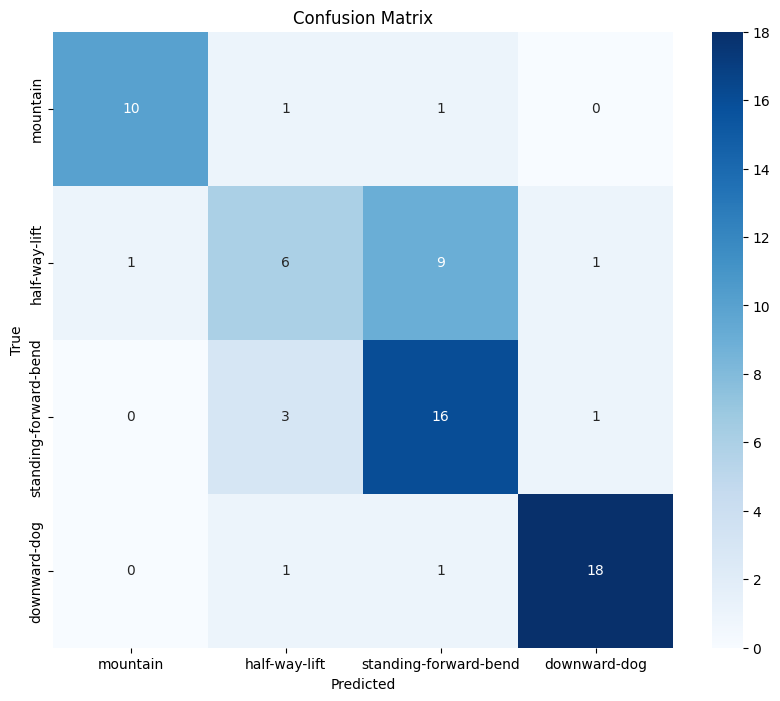

Test Loss: 1.2812
Test Accuracy: 72.46%


In [20]:
eval_best_model()

# TO EXAMINE THE DATASET FOR FAULTS


In [21]:
from tqdm import tqdm

def find_potential_label_errors(model, dataset, dataloader, threshold=0.9, device='cuda'):
    # Move model to GPU
    model = model.to(device)
    model.eval()

    potential_errors = {
        'sequence_id': [],
        'predicted_pose': [],
        'given_pose': [],
        'confidence': []
    }

    # Reverse mapping from index to pose name
    idx_to_pose = {v: k for k, v in dataset.pose_to_idx.items()}

    with torch.no_grad():
        for batch_idx, (sequences, labels, length) in enumerate(tqdm(dataloader, desc="Analyzing sequences")):
            # Move tensors to GPU
            sequences = sequences.to(device)
            labels = labels.to(device)
            length = length.to(device)

            # Get model predictions
            logits = model(sequences,length)  # Your raw logits
            probabilities = torch.nn.functional.softmax(logits, dim=1)
            predictions = torch.argmax(probabilities, dim=1)

            # Find high confidence disagreements
            for idx, (pred, true_label, prob) in enumerate(zip(predictions, labels, probabilities)):
                confidence = prob[pred].item()

                if pred != true_label and confidence > threshold:
                    # Get global index and sequence_id
                    global_idx = batch_idx * dataloader.batch_size + idx
                    sequence_id = dataset.df.iloc[global_idx]['sequence_id']

                    potential_errors['sequence_id'].append(sequence_id)
                    potential_errors['predicted_pose'].append(idx_to_pose[pred.item()])
                    potential_errors['given_pose'].append(idx_to_pose[true_label.item()])
                    potential_errors['confidence'].append(confidence)

    return potential_errors

def analyze_yoga_errors(potential_errors):
    """Analyze patterns in potential errors for yoga poses"""
    error_df = pd.DataFrame(potential_errors)

    print(f"Found {len(error_df)} potential errors")

    # Analyze pose-wise errors
    print("\nMost common incorrect labelings:")
    error_counts = error_df.groupby(['given_pose', 'predicted_pose']).size().sort_values(ascending=False)
    print(error_counts.head(10))

    # High confidence errors
    print("\nHighest confidence disagreements:")
    high_conf_errors = error_df.sort_values('confidence', ascending=False)
    print(high_conf_errors.head(10))

    return error_df

def validate_yoga_dataset(model, dataset, batch_size=8, threshold=0.9):
    dataloader = DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=False,
        collate_fn = collate_fn
    )

    # Find potential errors
    errors = find_potential_label_errors(model, dataset, dataloader, threshold)

    # Analyze and get DataFrame of errors
    error_df = analyze_yoga_errors(errors)

    return error_df
import torchvision.transforms as transforms
from PIL import Image
import torch

# Define de-normalization transform
imagenet_mean = [0.485, 0.456, 0.406]
imagenet_std = [0.229, 0.224, 0.225]
denormalize = transforms.Normalize(
    mean=[-m/s for m, s in zip(imagenet_mean, imagenet_std)],
    std=[1/s for s in imagenet_std]
)

def save_suspicious_sequences(error_df, dataset, save_dir, max_samples=5):
    """Save frames from suspicious sequences for manual review"""
    os.makedirs(save_dir, exist_ok=True)

    # Group by pose pairs to save examples of each type of error
    grouped_errors = error_df.groupby(['given_pose', 'predicted_pose'])

    for (given_pose, pred_pose), group in grouped_errors:
        # Take up to max_samples highest confidence examples for each error type
        samples = group.nlargest(max_samples, 'confidence')

        for idx, row in samples.iterrows():
            sequence_id = row['sequence_id']
            confidence = row['confidence']

            # Create directory for this error type
            error_dir = os.path.join(save_dir, f"{given_pose}_to_{pred_pose}")
            os.makedirs(error_dir, exist_ok=True)

            try:
                # Find the index in dataset.df that matches this sequence_id
                dataset_idx = dataset.df[dataset.df['sequence_id'] == sequence_id].index

                if len(dataset_idx) > 0:
                    # Get the sequence frames
                    frames, _ = dataset[dataset_idx[0]]

                    # Move frames to CPU if they're on GPU
                    if frames.is_cuda:
                        frames = frames.cpu()

                    # Save middle frame as representative image
                    middle_frame = frames[len(frames)//2]

                    # De-normalize the frame
                    middle_frame = denormalize(middle_frame)

                    # Clip the values to the valid range [0, 1] for image saving
                    middle_frame = torch.clamp(middle_frame, 0, 1)

                    save_path = os.path.join(error_dir, f'seq_{sequence_id}_conf_{confidence:.2f}.png')

                    # Convert tensor to PIL Image and save
                    middle_frame = transforms.ToPILImage()(middle_frame)
                    middle_frame.save(save_path)
                else:
                    print(f"Warning: Sequence ID {sequence_id} not found in dataset")

            except Exception as e:
                print(f"Error processing sequence {sequence_id}: {str(e)}")
                continue

# Usage example:

def search_all_the_faults():
    model = CNNLSTMATT(num_classes=NUM_CLASSES)
    aug_dirs={
        'flip': horz_aug,
        'blur': gaussian_blur_aug,
        'resize_crop': resize_aug
    }
    dataset = YogaVideoDataset(csv_path, sequence_path, pose_list, video_dir, preprocessed_dir, aug_dirs)
    checkpoint_path = os.path.join(save_path, 'best_model.pth')
    optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
    if checkpoint_path and os.path.exists(checkpoint_path):
      model, optimizer, start_epoch, history = load_checkpoint(
                model, optimizer, checkpoint_path
      )
      print(f"Resuming training from epoch {start_epoch}")
        # Find and analyze errors
    error_df = validate_yoga_dataset(model, dataset, batch_size=8, threshold=0.9)

        # Save suspicious sequences for manual review
    save_dir=os.path.join(save_path,'suspicious_sequences')
    save_suspicious_sequences(error_df, dataset, save_dir)

    csv_path_file = os.path.join(save_path, 'potential_label_errors.csv')
        # Export results to CSV for further analysis
    error_df.to_csv(csv_path_file, index=False)

        # Print some statistics
    print("\nMost frequently mislabeled sequences:")
    sequence_counts = error_df['sequence_id'].value_counts()
    print(sequence_counts.head())

In [22]:
search_all_the_faults()

KeyError: 'random_resized_crop'

In [36]:
mpath = os.path.join(save_path, 'my_model.pth')
checkpoint = torch.load(mpath, weights_only = True)
model = CNNLSTMATT(4)
model.load_state_dict(torch.load(mpath))

<ipython-input-36-f8420c95d2fd>:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(mpath))


<All keys matched successfully>

In [37]:
dataset = YogaVideoDataset(csv_path, sequence_path, pose_list, video_dir, preprocessed_dir)
train_dataset, val_dataset, test_dataset = train_val_test_split(dataset)
train_loader, val_loader, test_loader = create_data_loaders(train_dataset, val_dataset, test_dataset)

In [38]:
criterion = nn.CrossEntropyLoss()

Testing: 100%|██████████| 5/5 [00:17<00:00,  3.43s/it]


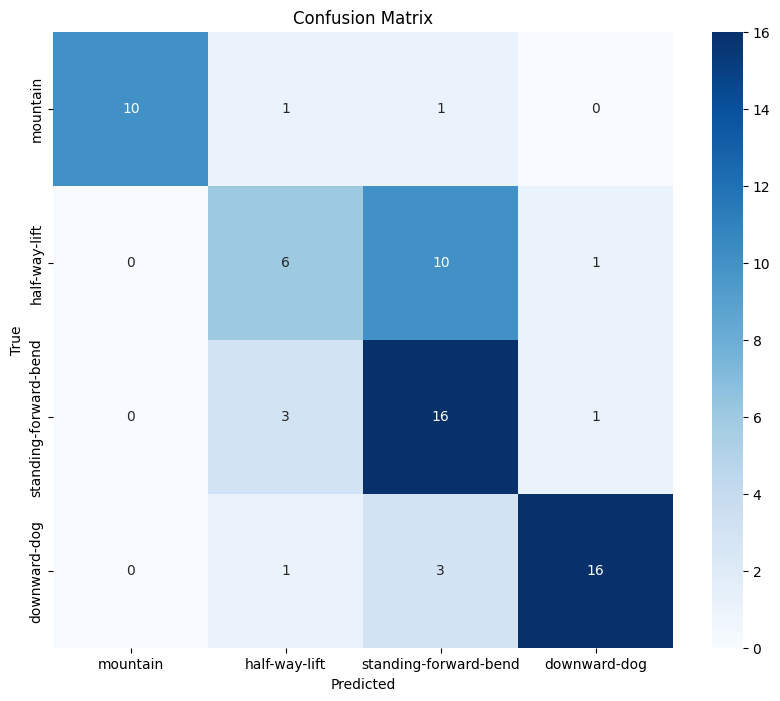

Test Loss: 1.4043
Test Accuracy: 69.57%


(1.4042926560277524, 69.56521739130434)

In [39]:
evaluate_model(model, test_loader, criterion, pose_list) #final model

Loading Data
Loading checkpoint from /content/gdrive/MyDrive/RGB_data_stream/nov12_unknown_attention/best_model.pth
Resuming training from epoch 19


Testing: 100%|██████████| 5/5 [00:21<00:00,  4.23s/it]


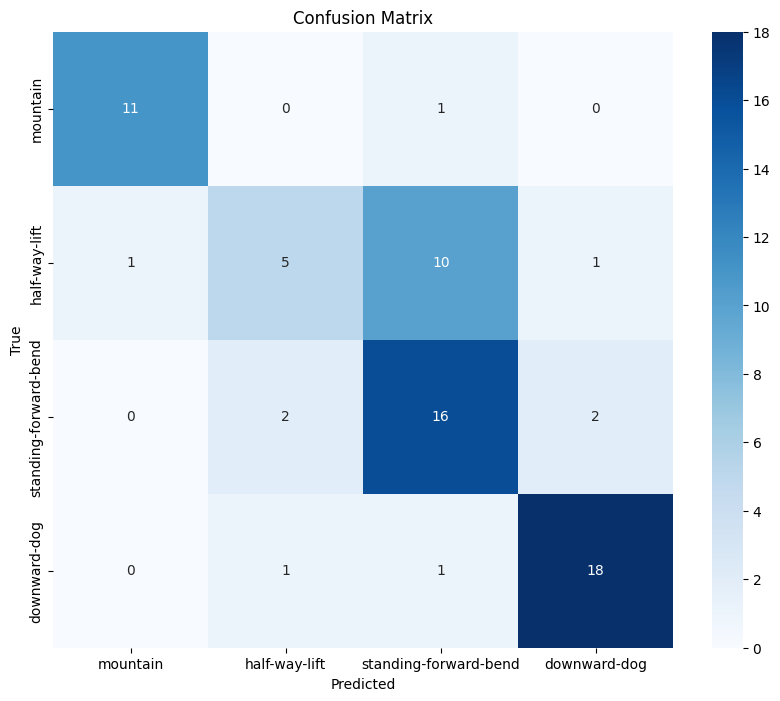

Test Loss: 1.3138
Test Accuracy: 72.46%


In [40]:
eval_best_model() # test model

Loading Data
Loading checkpoint from /content/gdrive/MyDrive/RGB_data_stream/nov12_unknown_attention/best_model.pth
Resuming training from epoch 19


Testing: 100%|██████████| 9/9 [00:36<00:00,  4.00s/it]


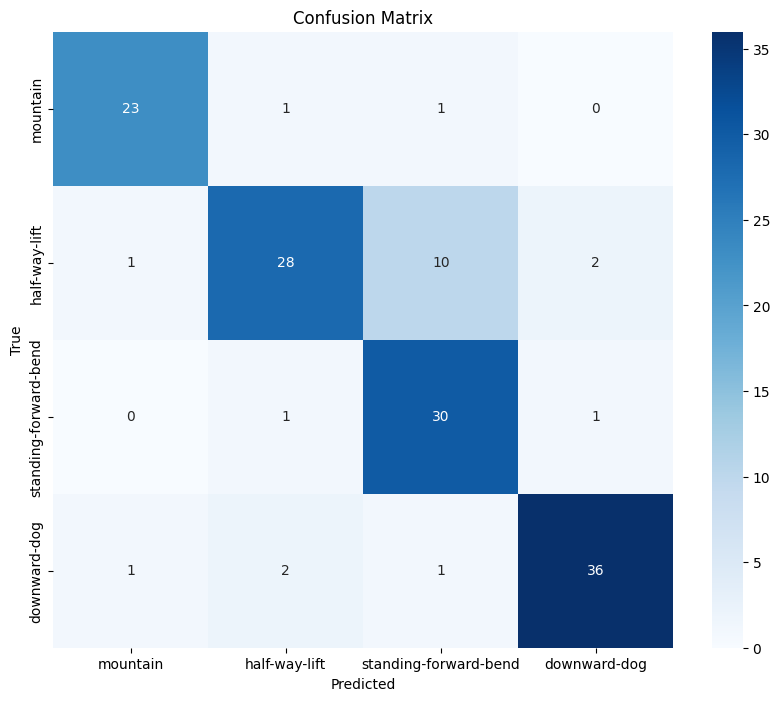

Test Loss: 0.8523
Test Accuracy: 84.78%


In [42]:
eval_best_model() # val set

Loading Data
Loading checkpoint from /content/gdrive/MyDrive/RGB_data_stream/nov12_unknown_attention/best_model.pth
Resuming training from epoch 19


Testing: 100%|██████████| 31/31 [02:10<00:00,  4.20s/it]


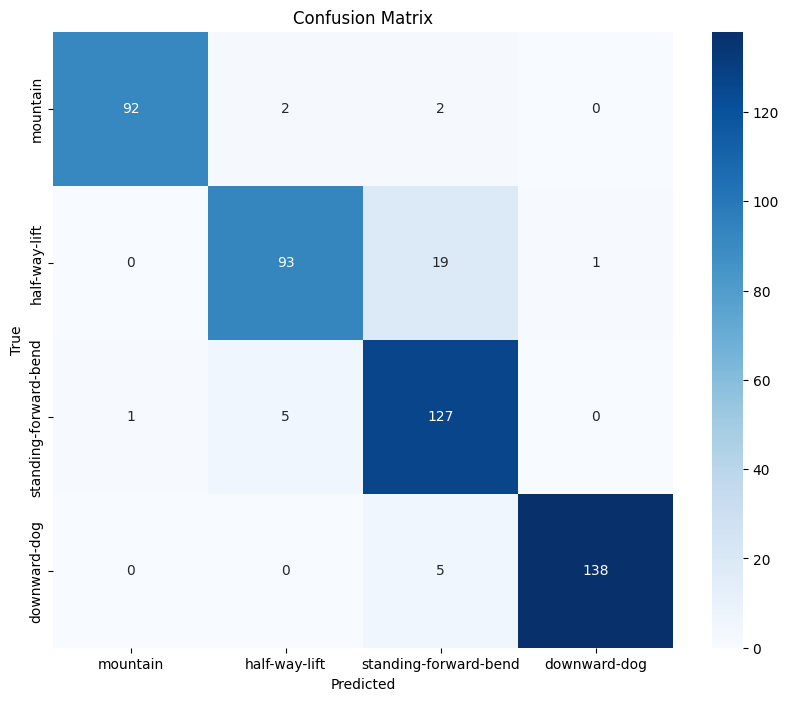

Test Loss: 0.2597
Test Accuracy: 92.78%


In [44]:
eval_best_model() # train set

Loading Data
Loading checkpoint from /content/gdrive/MyDrive/RGB_data_stream/nov12_unknown_attention/best_model.pth
Resuming training from epoch 19


Testing: 100%|██████████| 5/5 [00:23<00:00,  4.79s/it]


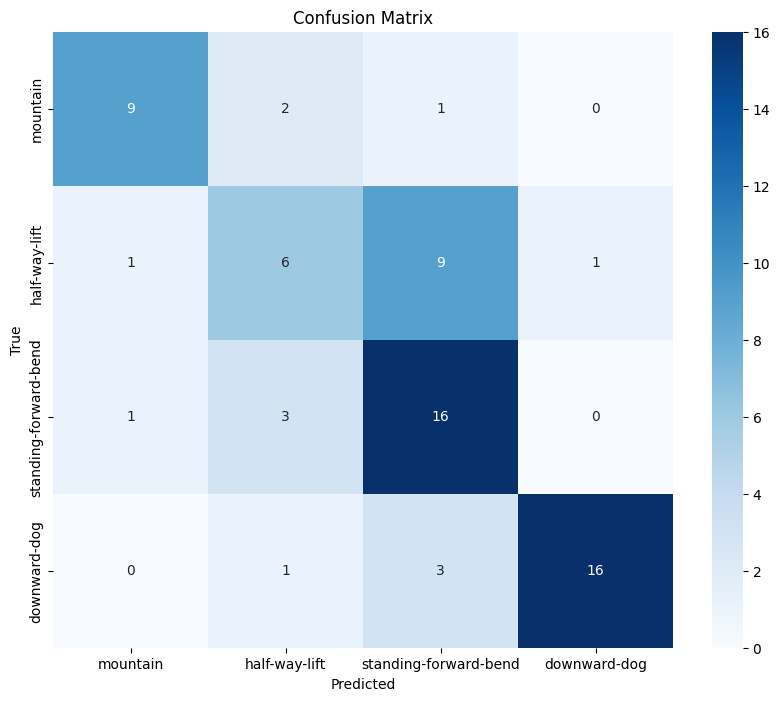

Test Loss: 1.4104
Test Accuracy: 68.12%


In [46]:
eval_best_model() #test set